In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from datetime import datetime
import logging
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
import gc  # for garbage collection
import os

In [2]:
#load in the data using xarray 
merra2_data=xr.open_dataset("merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc", engine="netcdf4")
nldas_data= xr.open_dataset("nldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
fldas_data= xr.open_dataset("fldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
gldas_data= xr.open_dataset("gldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
era5_data=xr.open_dataset('/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',engine='cfgrib')

#create dataset dictionary 

datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

# Define variable names for each dataset
var_names = {
    'MERRA2': 'SFMC',  # Surface soil moisture content
    'NLDAS': 'SoilM_0_10cm',
    'FLDAS': 'SoilMoi00_10cm_tavg',
    'GLDAS': 'SoilMoi0_10cm_inst',
    'ERA5': 'swvl1'  # Volumetric soil water layer 1
}

coord_mapping = {
    'NLDAS': {'lat': 'lat', 'lon': 'lon'},
    'GLDAS': {'lat': 'lat', 'lon': 'lon'},
    'FLDAS': {'lat': 'Y', 'lon': 'X'},
    'ERA5': {'lat': 'latitude', 'lon': 'longitude'},
    'MERRA2': {'lat': 'lat', 'lon': 'lon'}
}


Normalization stats for MERRA2:
Original mean: 0.2624, std: 0.0585
Normalized mean: -0.0000, std: 1.0000

Normalization stats for NLDAS:
Original mean: 29.3776, std: 7.0058
Normalized mean: 0.0000, std: 1.0001

Normalization stats for FLDAS:
Original mean: 0.3622, std: 0.0497
Normalized mean: -0.0000, std: 1.0001

Normalization stats for GLDAS:
Original mean: 31.4795, std: 6.4977
Normalized mean: -0.0000, std: 1.0000

Normalization stats for ERA5:
Original mean: 0.3042, std: 0.0944
Normalized mean: 0.0000, std: 1.0000

=== Data Diagnostics Report ===

--------------------
MERRA2
--------------------
Shape: 132 × 10 × 13
Memory Usage: 0.13 MB
Value Range: -3.0492 to 2.4703
Mean ± Std: -0.0000 ± 1.0000
Median (IQR): 0.0376 (1.3878)
Missing Data: 0.00%
Outliers: 0.17%

--------------------
NLDAS
--------------------
Shape: 132 × 36 × 63
Memory Usage: 2.28 MB
Value Range: -3.7698 to 2.6010
Mean ± Std: 0.0000 ± 1.0001
Median (IQR): -0.1468 (1.1717)
Missing Data: 10.49%
Outliers: 2.84%

---

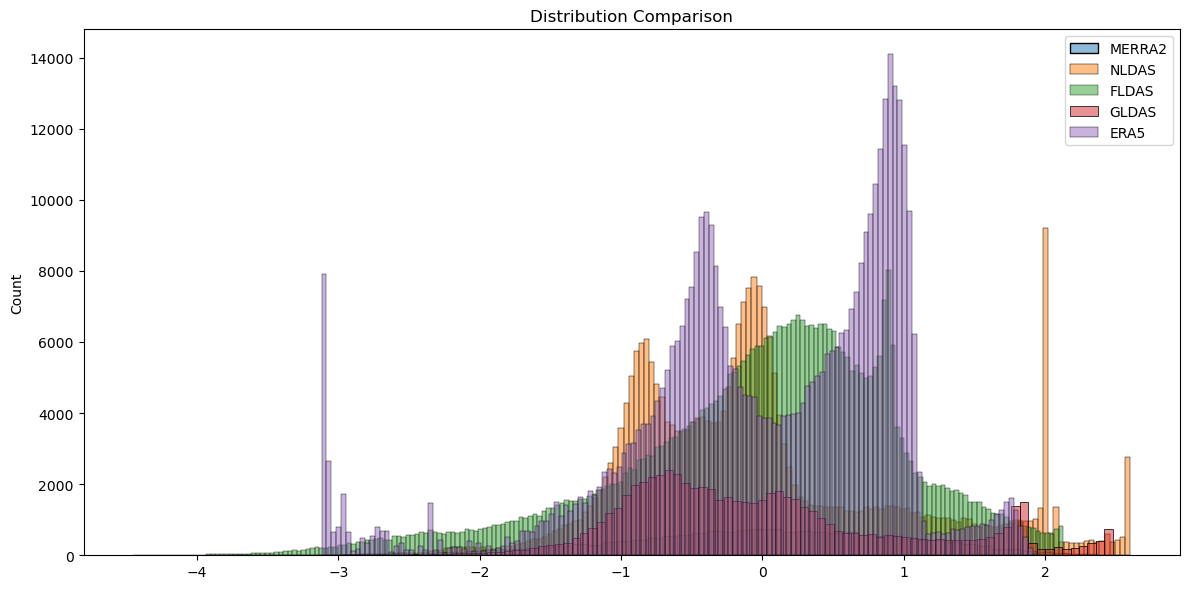


=== Cross-Dataset Comparison ===
         Mean     Std  Missing_Percentage  Outlier_Percentage
Dataset                                                      
MERRA2   -0.0  1.0000              0.0000              0.1690
NLDAS     0.0  1.0001             10.4938              2.8422
FLDAS    -0.0  1.0001             10.4641              3.1350
GLDAS    -0.0  1.0000             10.2431              2.1159
ERA5      0.0  1.0000              3.3152              4.0174


In [3]:
import xarray as xr
import numpy as np
import pandas as pd
from typing import Dict, Union
import seaborn as sns
import matplotlib.pyplot as plt

# Define dataset configurations
DATA_CONFIG = {
    'MERRA2': {
        'path': "merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc",
        'var_name': 'SFMC',
        'coords': {'lat': 'lat', 'lon': 'lon'},
        'engine': 'netcdf4'
    },
    'NLDAS': {
        'path': "nldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilM_0_10cm',
        'coords': {'lat': 'lat', 'lon': 'lon'},
        'engine': 'netcdf4'
    },
    'FLDAS': {
        'path': "fldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilMoi00_10cm_tavg',
        'coords': {'lat': 'Y', 'lon': 'X'},
        'engine': 'netcdf4'
    },
    'GLDAS': {
        'path': "gldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilMoi0_10cm_inst',
        'coords': {'lat': 'lat', 'lon': 'lon'},
        'engine': 'netcdf4'
    },
    'ERA5': {
        'path': '/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',
        'var_name': 'swvl1',
        'coords': {'lat': 'latitude', 'lon': 'longitude'},
        'engine': 'cfgrib'
    }
}

def load_datasets() -> Dict[str, xr.Dataset]:
    """Load all datasets using the configuration dictionary."""
    return {name: xr.open_dataset(config['path'], engine=config['engine'])
            for name, config in DATA_CONFIG.items()}

def normalize_datasets(datasets_dict: Dict[str, xr.Dataset]) -> Dict[str, xr.DataArray]:
    """
    Normalize each dataset by removing the mean and dividing by the standard deviation.
    
    Parameters:
    -----------
    datasets_dict : Dict[str, xr.Dataset]
        Dictionary of datasets with model names as keys
        
    Returns:
    --------
    Dict[str, xr.DataArray]
        Dictionary of normalized datasets
    """
    normalized_datasets = {}
    
    for name, data in datasets_dict.items():
        try:
            # Get the variable name from config
            var_name = DATA_CONFIG[name]['var_name']
            
            # Extract the data array
            data_array = data[var_name]
            
            # Calculate mean and standard deviation along all dimensions
            mean = data_array.mean()
            std = data_array.std()
            
            # Normalize the data
            normalized_data = (data_array - mean) / std
            
            # Store the normalized dataset
            normalized_datasets[name] = normalized_data
            
            # Print statistics for verification
            print(f"\nNormalization stats for {name}:")
            print(f"Original mean: {mean.values:.4f}, std: {std.values:.4f}")
            print(f"Normalized mean: {normalized_data.mean().values:.4f}, std: {normalized_data.std().values:.4f}")
            
        except Exception as e:
            print(f"Error normalizing {name}: {str(e)}")
            continue
    
    return normalized_datasets

def check_data_properties(datasets_dict: Dict[str, Union[xr.Dataset, xr.DataArray]], 
                         plot_distributions: bool = True) -> pd.DataFrame:
    """
    Comprehensive diagnostic check of soil moisture datasets.
    
    Parameters:
    -----------
    datasets_dict : Dict
        Dictionary of datasets with model names as keys
    plot_distributions : bool
        Whether to plot distribution visualizations
        
    Returns:
    --------
    pd.DataFrame
        Summary statistics for all datasets
    """
    stats_list = []
    
    if plot_distributions:
        plt.figure(figsize=(12, 6))
        plt.title('Soil Moisture Data Distributions')
    
    print("\n=== Data Diagnostics Report ===")
    
    for name, data in datasets_dict.items():
        print(f"\n{'-'*20}\n{name}\n{'-'*20}")
        
        try:
            var_name = DATA_CONFIG[name]['var_name']
            data_array = data[var_name] if isinstance(data, xr.Dataset) else data
            
            if not isinstance(data_array, xr.DataArray):
                raise TypeError(f"Expected xarray.DataArray, got {type(data_array)}")
            
            values = data_array.values
            flattened = values.flatten()
            valid_values = flattened[~np.isnan(flattened)]
            
            # Calculate statistics
            stats = {
                'Dataset': name,
                **{metric: func(valid_values) for metric, func in {
                    'Mean': np.mean,
                    'Std': np.std,
                    'Min': np.min,
                    'Max': np.max
                }.items()},
                'NaN_Count': np.sum(np.isnan(flattened)),
                'Total_Values': len(flattened),
                'Valid_Values': len(valid_values),
                'Missing_Percentage': (np.sum(np.isnan(flattened)) / len(flattened)) * 100,
                'Dimensions': ' × '.join(map(str, values.shape)),
                'Memory_MB': values.nbytes / (1024 * 1024)
            }
            
            # Add quartile statistics
            quartiles = np.percentile(valid_values, [25, 50, 75])
            stats.update({
                'Q1': quartiles[0],
                'Median': quartiles[1],
                'Q3': quartiles[2],
                'IQR': quartiles[2] - quartiles[0]
            })
            
            # Calculate outliers
            iqr = stats['IQR']
            bounds = (stats['Q1'] - (1.5 * iqr), stats['Q3'] + (1.5 * iqr))
            outliers = np.sum((valid_values < bounds[0]) | (valid_values > bounds[1]))
            stats.update({
                'Outlier_Count': outliers,
                'Outlier_Percentage': (outliers / len(valid_values)) * 100
            })
            
            stats_list.append(stats)
            
            # Print report
            print(f"Shape: {stats['Dimensions']}")
            print(f"Memory Usage: {stats['Memory_MB']:.2f} MB")
            print(f"Value Range: {stats['Min']:.4f} to {stats['Max']:.4f}")
            print(f"Mean ± Std: {stats['Mean']:.4f} ± {stats['Std']:.4f}")
            print(f"Median (IQR): {stats['Median']:.4f} ({stats['IQR']:.4f})")
            print(f"Missing Data: {stats['Missing_Percentage']:.2f}%")
            print(f"Outliers: {stats['Outlier_Percentage']:.2f}%")
            
            if plot_distributions:
                sns.histplot(valid_values, label=name, alpha=0.5)
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue
    
    if plot_distributions:
        plt.title('Distribution Comparison')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    summary_df = pd.DataFrame(stats_list).set_index('Dataset')
    
    print("\n=== Cross-Dataset Comparison ===")
    print(summary_df[['Mean', 'Std', 'Missing_Percentage', 'Outlier_Percentage']].round(4))
    
    return summary_df

# Example usage:
if __name__ == "__main__":
    # Load original datasets
    datasets = load_datasets()
    
    # Normalize datasets
    normalized_datasets = normalize_datasets(datasets)
    
    # Optionally, you can check the distributions of normalized data
    summary_stats = check_data_properties(normalized_datasets, plot_distributions=True)
    


Normalization stats for MERRA2:
Original mean: 0.2624, std: 0.0585
Normalized mean: -0.0000, std: 1.0000

Normalization stats for NLDAS:
Original mean: 29.3776, std: 7.0058
Normalized mean: 0.0000, std: 1.0001

Normalization stats for FLDAS:
Original mean: 0.3622, std: 0.0497
Normalized mean: -0.0000, std: 1.0001

Normalization stats for GLDAS:
Original mean: 31.4795, std: 6.4977
Normalized mean: -0.0000, std: 1.0000

Normalization stats for ERA5:
Original mean: 0.3042, std: 0.0944
Normalized mean: 0.0000, std: 1.0000


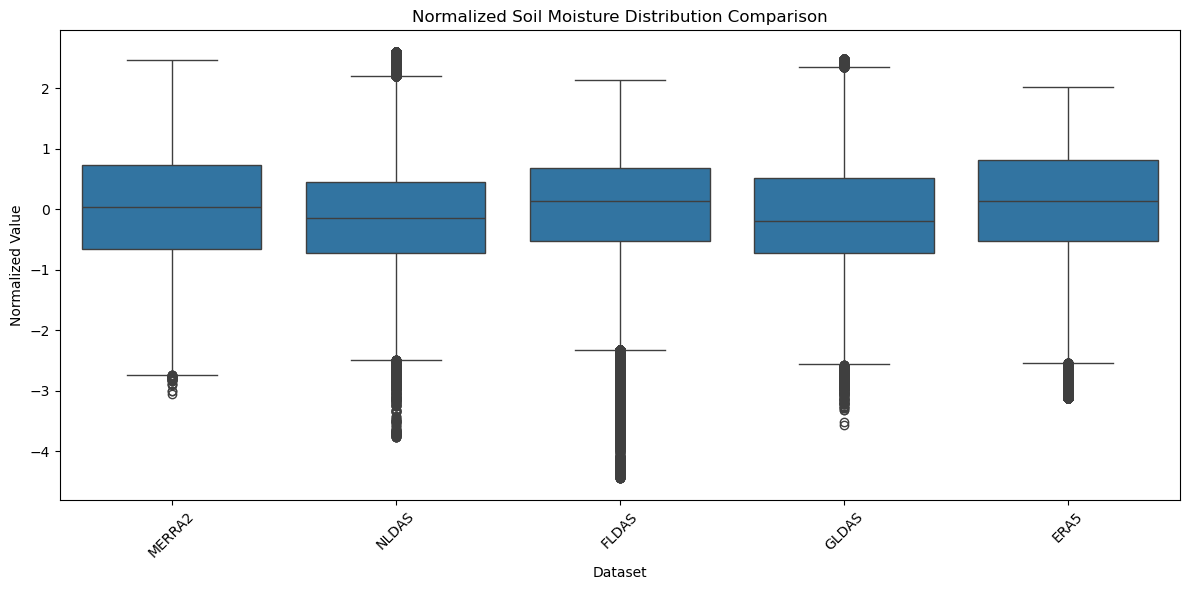

In [4]:
#plot box plots for each normalized dataset 

def create_boxplot_all_datasets(datasets, normalized=False):
    """
    Create a box plot comparing all soil moisture datasets.
    
    Parameters:
    -----------
    datasets : dict
        Dictionary containing dataset names and their corresponding xarray Datasets
    normalized : bool
        Whether the data is normalized (affects title and y-axis label)
    """
    # Prepare data for plotting
    plot_data = []
    
    for name, data in datasets.items():
        if isinstance(data, xr.Dataset):
            var_name = DATA_CONFIG[name]['var_name']
            values = data[var_name].values.flatten()
        else:  # For normalized data (xr.DataArray)
            values = data.values.flatten()
            
        valid_values = values[~np.isnan(values)]
        
        # Create DataFrame entries for this dataset
        plot_data.extend({
            'Dataset': name,
            'Value': val
        } for val in valid_values)
    
    # Convert to DataFrame
    df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Dataset', y='Value')
    
    title = 'Normalized Soil Moisture Distribution Comparison' if normalized else 'Soil Moisture Distribution Comparison'
    plt.title(title)
    plt.ylabel('Normalized Value' if normalized else 'Soil Moisture')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Load original datasets
    datasets = load_datasets()
    
    # Normalize datasets
    normalized_datasets = normalize_datasets(datasets)
    
    # Create boxplot for normalized data
    create_boxplot_all_datasets(normalized_datasets, normalized=True)

In [2]:
from typing import Dict, Tuple
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xesmf as xe

def create_land_mask(era5_data: xr.Dataset) -> xr.DataArray:
    """
    Create a land mask using ERA5 data.
    Returns a boolean mask where True indicates land.
    """
    try:
        # Try to get land-sea mask if it exists in the ERA5 dataset
        if 'lsm' in era5_data:
            mask = era5_data['lsm'] > 0.5  # Convert to boolean mask
        else:
            # If no explicit mask, use soil moisture values
            # Assuming persistent NaN or zero values indicate water bodies
            mask = ~np.isnan(era5_data[DATA_CONFIG['ERA5']['var_name']].isel(time=0))
            mask = mask & (era5_data[DATA_CONFIG['ERA5']['var_name']].isel(time=0) != 0)
        
        print("Land mask created successfully")
        print(f"Land points: {mask.sum().values}")
        print(f"Total points: {mask.size}")
        print(f"Land percentage: {(mask.sum().values / mask.size * 100):.1f}%")
        
        return mask
    except Exception as e:
        print(f"Error creating land mask: {str(e)}")
        return None

def regrid_normalize_and_correlate(datasets: Dict[str, xr.Dataset]) -> Tuple[Dict[str, xr.DataArray], pd.DataFrame, pd.DataFrame]:
    """
    Regrid all datasets to ERA5 grid using bilinear interpolation, normalize them, 
    and compute correlation statistics. Applies consistent land mask.
    """
    names = list(datasets.keys())
    n_datasets = len(names)
    
    # Get reference coordinates from ERA5
    era5_data = datasets['ERA5']
    
    # Create land mask
    land_mask = create_land_mask(era5_data)
    if land_mask is None:
        raise ValueError("Failed to create land mask")
    
    # Initialize matrices
    correlation_matrix = np.zeros((n_datasets, n_datasets))
    shared_variance_matrix = np.zeros((n_datasets, n_datasets))
    
    # Initialize regridded data dictionary
    regridded_data = {}
    
    # First handle ERA5 (reference dataset)
    era5_var = DATA_CONFIG['ERA5']['var_name']
    era5_array = era5_data[era5_var]
    
    # Apply land mask to ERA5
    era5_masked = era5_array.where(land_mask)
    
    # Normalize ERA5
    regridded_data['ERA5'] = (era5_masked - era5_masked.mean()) / era5_masked.std()
    
    # Create target grid dataset for regridding
    ds_out = xr.Dataset(
        {
            'lat': (['lat'], era5_array.latitude.values),
            'lon': (['lon'], era5_array.longitude.values)
        }
    )
    
    # Regrid and normalize each non-ERA5 dataset
    for name in names:
        if name == 'ERA5':
            continue
            
        try:
            data = datasets[name]
            var_name = DATA_CONFIG[name]['var_name']
            coords = DATA_CONFIG[name]['coords']
            
            # Extract variable
            data_array = data[var_name]
            
            # Rename coordinates if needed
            if coords['lat'] != 'lat' or coords['lon'] != 'lon':
                data_array = data_array.rename({
                    coords['lat']: 'lat',
                    coords['lon']: 'lon'
                })
            
            # Handle potential coordinate ordering issues
            if data_array.lat.values[0] > data_array.lat.values[-1]:
                data_array = data_array.reindex(lat=data_array.lat[::-1])
            
            # Create regridder
            regridder = xe.Regridder(
                data_array,
                ds_out,
                'bilinear',
                periodic=True
            )
            
            # Perform regridding
            regridded = regridder(data_array)
            
            # Ensure consistent dimensions ordering
            regridded = regridded.transpose('time', 'lat', 'lon')
            
            # Apply land mask
            regridded_masked = regridded.where(land_mask)
            
            # Normalize
            regridded_normalized = (regridded_masked - regridded_masked.mean()) / regridded_masked.std()
            
            regridded_data[name] = regridded_normalized
            
            print(f"\nSuccessfully processed {name}")
            print(f"Original shape: {data_array.shape}")
            print(f"Regridded shape: {regridded.shape}")
            print(f"Valid points after masking: {(~np.isnan(regridded_masked)).sum().values}")
            print(f"Normalized range: {regridded_normalized.min().values:.2f} to {regridded_normalized.max().values:.2f}")
            
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue
    
    # Calculate correlations
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            try:
                if name1 not in regridded_data or name2 not in regridded_data:
                    continue
                    
                data1 = regridded_data[name1]
                data2 = regridded_data[name2]
                
                # Calculate temporal correlation at each point
                correlations = []
                
                # Get the data values
                vals1 = data1.values
                vals2 = data2.values
                
                # Create mask for valid data
                valid_mask = ~(np.isnan(vals1) | np.isnan(vals2))
                
                # Calculate correlations for each spatial point
                for lat_idx in range(vals1.shape[1]):
                    for lon_idx in range(vals1.shape[2]):
                        ts1 = vals1[:, lat_idx, lon_idx]
                        ts2 = vals2[:, lat_idx, lon_idx]
                        
                        # Check for valid data at this point
                        mask = valid_mask[:, lat_idx, lon_idx]
                        if np.sum(mask) > 1:  # Need at least 2 points for correlation
                            ts1_clean = ts1[mask]
                            ts2_clean = ts2[mask]
                            
                            corr = np.corrcoef(ts1_clean, ts2_clean)[0,1]
                            
                            if not np.isnan(corr):
                                correlations.append(corr)
                
                if correlations:
                    mean_correlation = np.mean(correlations)
                    shared_variance = (mean_correlation ** 2) * 100
                    
                    correlation_matrix[i,j] = mean_correlation
                    shared_variance_matrix[i,j] = shared_variance
                    
                    print(f"\n{name1} vs {name2}:")
                    print(f"Valid points: {len(correlations)}")
                    print(f"Mean correlation: {mean_correlation:.4f}")
                    print(f"Shared variance: {shared_variance:.1f}%")
                else:
                    correlation_matrix[i,j] = np.nan
                    shared_variance_matrix[i,j] = np.nan
                    
            except Exception as e:
                print(f"Error processing {name1} and {name2}: {str(e)}")
                correlation_matrix[i,j] = np.nan
                shared_variance_matrix[i,j] = np.nan
    
    # Create DataFrames
    corr_df = pd.DataFrame(correlation_matrix, 
                          index=names, 
                          columns=names)
    r2_df = pd.DataFrame(shared_variance_matrix, 
                        index=names, 
                        columns=names)
    
    return regridded_data, corr_df, r2_df

In [3]:

# First make sure we have our configuration dictionary defined
DATA_CONFIG = {
    'MERRA2': {
        'path': "merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc",
        'var_name': 'SFMC',
        'coords': {'lat': 'lat', 'lon': 'lon'}
    },
    'NLDAS': {
        'path': "nldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilM_0_10cm',
        'coords': {'lat': 'lat', 'lon': 'lon'}
    },
    'FLDAS': {
        'path': "fldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilMoi00_10cm_tavg',
        'coords': {'lat': 'Y', 'lon': 'X'}
    },
    'GLDAS': {
        'path': "gldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilMoi0_10cm_inst',
        'coords': {'lat': 'lat', 'lon': 'lon'}
    },
    'ERA5': {
        'path': '/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',
        'var_name': 'swvl1',
        'coords': {'lat': 'latitude', 'lon': 'longitude'}
    }
}

# Load datasets
def load_datasets():
    datasets = {}
    for name, config in DATA_CONFIG.items():
        try:
            if config['path'].endswith('.grib'):
                ds = xr.open_dataset(config['path'], engine='cfgrib')
            else:
                ds = xr.open_dataset(config['path'])
            datasets[name] = ds
            print(f"Successfully loaded {name}")
        except Exception as e:
            print(f"Error loading {name}: {str(e)}")
    return datasets

if __name__ == "__main__":
    # Load the datasets
    print("Loading datasets...")
    datasets = load_datasets()
    
    # Run the analysis
    print("\nProcessing datasets...")
    regridded_data, correlation_matrix, shared_variance_matrix = regrid_normalize_and_correlate(datasets)
    
    # Plot correlation and shared variance matrices
    print("\nCreating visualizations...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Correlation heatmap
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='RdBu_r', 
                center=0, 
                vmin=-1,
                vmax=1,
                fmt='.3f',
                ax=ax1,
                square=True)
    ax1.set_title('Spatial Correlation Matrix')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

    # Shared variance heatmap
    sns.heatmap(shared_variance_matrix, 
                annot=True, 
                cmap='YlOrRd', 
                fmt='.1f',
                ax=ax2,
                square=True)
    ax2.set_title('Shared Variance Matrix (%)')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()
    
    # Optionally, save the matrices
    correlation_matrix.to_csv('correlation_matrix.csv')
    shared_variance_matrix.to_csv('shared_variance_matrix.csv')
    
    # Plot example maps of the regridded, masked data
    for name, data in regridded_data.items():
        plt.figure(figsize=(12, 6))
        data.isel(time=0).plot(
            cmap='RdYlBu',
            robust=True,
            cbar_kwargs={'label': 'Normalized Soil Moisture'}
        )
        plt.title(f'{name} - First Time Step (Normalized)')
        plt.show()

Loading datasets...
Successfully loaded MERRA2
Successfully loaded NLDAS
Successfully loaded FLDAS
Successfully loaded GLDAS
Successfully loaded ERA5

Processing datasets...
Land mask created successfully
Land points: 3558
Total points: 3680
Land percentage: 96.7%

Successfully processed MERRA2
Original shape: (132, 10, 13)
Regridded shape: (132, 46, 80)
Valid points after masking: 1728334080
Normalized range: -4.92 to 3.33

Successfully processed NLDAS
Original shape: (132, 36, 63)
Regridded shape: (132, 46, 80)
Valid points after masking: 1368107928
Normalized range: -3.76 to 2.96

Successfully processed FLDAS
Original shape: (132, 45, 79)
Regridded shape: (132, 46, 80)
Valid points after masking: 1288736064
Normalized range: -5.89 to 2.31


: 